
# Tutorial: Traj Preprocessing

**The following notebook illustrate the `TrajPreprocessing` class how to run the preprocessing steps.**
- **Several preprocessing steps are available for the tail angle**:
  - Interpolating missing values
  - Apply 1€ filter

- **The kinematic vigor is also computed from the speed and will also be useful for segmentation into bouts**:



* Loading dependencies

In [2]:
from IPython.display import SVG, display

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from megabouts.tracking_data.tracking_data import TrackingConfig
from megabouts.tracking_data.load_example import load_example_data
from megabouts.tracking_data.tracking_data import FullTrackingData

from megabouts.preprocessing.traj_preprocessing import TrajPreprocessingConfig
from megabouts.preprocessing.traj_preprocessing import TrajPreprocessingResult
from megabouts.preprocessing.traj_preprocessing import TrajPreprocessing

## Loading Data

* TrackingConfig and TrackingData similar to [tutorial_Loading_Data](./tutorial_Loading_Data.ipynb)

In [3]:
# Load data and set tracking configuration
df_recording, fps, mm_per_unit = load_example_data('SLEAP_fulltracking')
tracking_cfg = TrackingConfig(fps=fps, tracking='full_tracking')

# List of keypoints
keypoints = ['left_eye', 'right_eye', 'tail0', 'tail1', 'tail2', 'tail3', 'tail4']

# Place NaN where the score is below a threshold
thresh_score = 0.
for kps in keypoints:
    score_below_thresh = df_recording['instance.score'] < thresh_score
    df_recording.loc[score_below_thresh | (df_recording[f'{kps}.score'] < thresh_score), [f'{kps}.x', f'{kps}.y']] = np.nan

# Compute head and tail coordinates and convert to mm
head_x = ((df_recording['left_eye.x'] + df_recording['right_eye.x']) / 2) * mm_per_unit
head_y = ((df_recording['left_eye.y'] + df_recording['right_eye.y']) / 2) * mm_per_unit
tail_x = df_recording[[f'tail{i}.x' for i in range(5)]].values * mm_per_unit
tail_y = df_recording[[f'tail{i}.y' for i in range(5)]].values * mm_per_unit

# Create FullTrackingData object
tracking_data = FullTrackingData.from_keypoints(head_x=head_x.values,
                                                head_y=head_y.values,
                                                tail_x=tail_x,
                                                tail_y=tail_y)


In [14]:
df_recording, fps, mm_per_unit = load_example_data('fulltracking_posture')

tracking_cfg = TrackingConfig(fps=fps, tracking='full_tracking')

head_x = df_recording['head_x'].values*mm_per_unit
head_y = df_recording['head_y'].values*mm_per_unit
head_yaw = df_recording['head_angle'].values
tail_angle = df_recording.filter(like='tail_angle').values

tracking_data = FullTrackingData.from_posture(head_x = head_x,
                                              head_y = head_y,
                                              head_yaw = head_yaw,
                                              tail_angle = tail_angle)

In [4]:
from megabouts.utils.utils_downsampling import create_downsampling_function


In [16]:
df_recording, fps, mm_per_unit = load_example_data('fulltracking_posture')


head_x = df_recording['head_x'].values*mm_per_unit
head_y = df_recording['head_y'].values*mm_per_unit
head_yaw = df_recording['head_angle'].values
tail_angle = df_recording.filter(like='tail_angle').values

fps = 60
downsampling_f, _, _, _ = create_downsampling_function(fps, 700, len(head_x) * 1000 / 700)
head_x = downsampling_f(head_x, axis=0)
head_y = downsampling_f(head_y, axis=0)
head_yaw = downsampling_f(head_yaw, axis=0)
tail_angle = downsampling_f(tail_angle, axis=0)

tracking_cfg = TrackingConfig(fps=fps, tracking='full_tracking')

tracking_data = FullTrackingData.from_posture(head_x = head_x,
                                              head_y = head_y,
                                              head_yaw = head_yaw,
                                              tail_angle = tail_angle)

## Run Preprocessing

* Define preprocessing config

In [5]:
traj_preprocessing_cfg = TrajPreprocessingConfig(fps=tracking_cfg.fps)

In [6]:
traj_df_input = tracking_data.traj_df

traj = TrajPreprocessing(traj_preprocessing_cfg).preprocess_traj_df(traj_df_input)

In [7]:
traj.df.head(5)

,x,y,yaw,x_smooth,y_smooth,yaw_smooth,axial_speed,lateral_speed,yaw_speed,vigor,no_tracking
0,20.381254,20.996582,1.491111,20.381254,20.996582,1.491111,NaN,NaN,NaN,0.0,0.0
1,20.381340,20.996807,1.491013,20.381277,20.996642,1.491085,NaN,NaN,NaN,0.0,0.0
2,20.381337,20.997020,1.491086,20.381293,20.996742,1.491085,NaN,NaN,NaN,0.0,0.0
3,20.418551,20.997656,1.430916,20.391138,20.996983,1.475189,NaN,NaN,NaN,0.0,0.0
4,20.418671,20.997872,1.430749,20.399294,20.997219,1.461210,0.293531,-1.616157,-2.659344,0.0,0.0


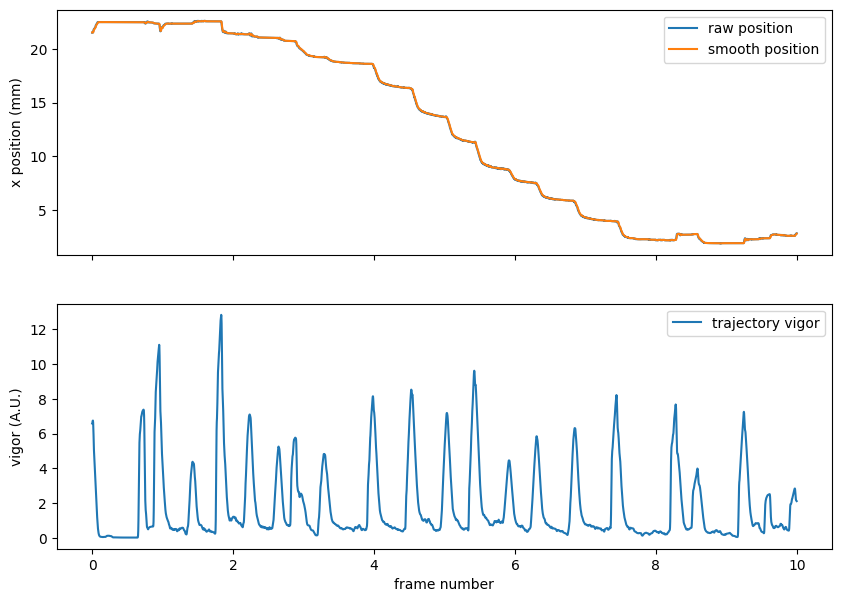

In [8]:
t = np.arange(tracking_data.T)/tracking_cfg.fps
IdSt = np.random.randint(tracking_data.T)
Duration = 10*tracking_cfg.fps

t_win = t[IdSt:IdSt+Duration]-t[IdSt]
fig,ax = plt.subplots(2,1,figsize=(10,7),sharex=True)
ax[0].plot(t_win,traj.x[IdSt:IdSt+Duration],label='raw position')
ax[0].plot(t_win,traj.x_smooth[IdSt:IdSt+Duration],label='smooth position')
ax[1].plot(t_win,traj.vigor[IdSt:IdSt+Duration],label='trajectory vigor')
ax[0].set(ylabel='x position (mm)')
ax[1].set(ylabel='vigor (A.U.)')
ax[1].set(xlabel='frame number')

for i in range(2):
    ax[i].legend()
plt.show()

# Tuning [1€ filter](https://gery.casiez.net/1euro/)

> &#x1F4DD;	
> There are two configurable parameters in the filter, the minimum cutoff frequency `freq_cutoff_min` and the speed coefficient `beta`.\
> Decreasing the minimum cutoff frequency decreases slow speed jitter. Increasing the speed coefficient decreases speed lag.\
> The parameters are set using two-step procedure:

### **Step 1**

**`beta` is set to 0 and `freq_cutoff_min` to 10Hz. Focus on a part of the recording where the fish is not swimming or swimming at low speed.\
 `freq_cutoff_min` is adjusted to remove jitter and preserve an acceptable lag during these slow movements.**

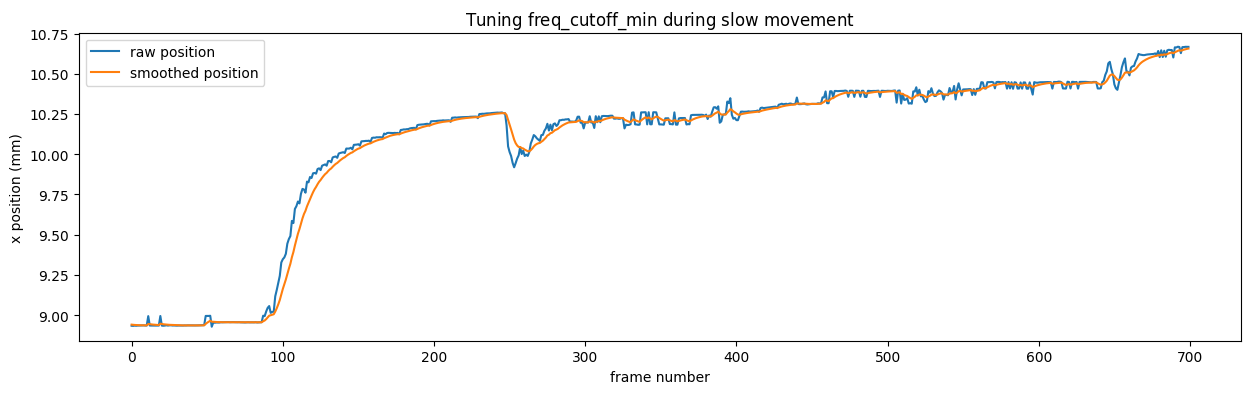

In [56]:
IdSt = 55000
Duration = 2*tracking_cfg.fps

x = traj.x
x_smooth = TrajPreprocessing.one_euro_filter(x,freq_cutoff_min=10,beta = 0, rate = tracking_cfg.fps)

fig,ax = plt.subplots(1,1,figsize=(15,4),sharex=True)
ax.set_title('Tuning '+ r'$\text{freq_cutoff_min}$'+ ' during slow movement')
ax.plot(x[IdSt:IdSt+Duration],label='raw position')
ax.plot(x_smooth[IdSt:IdSt+Duration],label='smoothed position')
ax.set(xlabel='frame number',ylabel='x position (mm)')
ax.legend()
plt.show()

&#x2705;	 Here a value close to 10Hz for `freq_cutoff_min` allows to smooth while keeping an acceptable lag*

### **Step 2**

**Focus on a part of the recording where the fish is moving fast. Adjust `beta` with a focus on minimizing lag.**

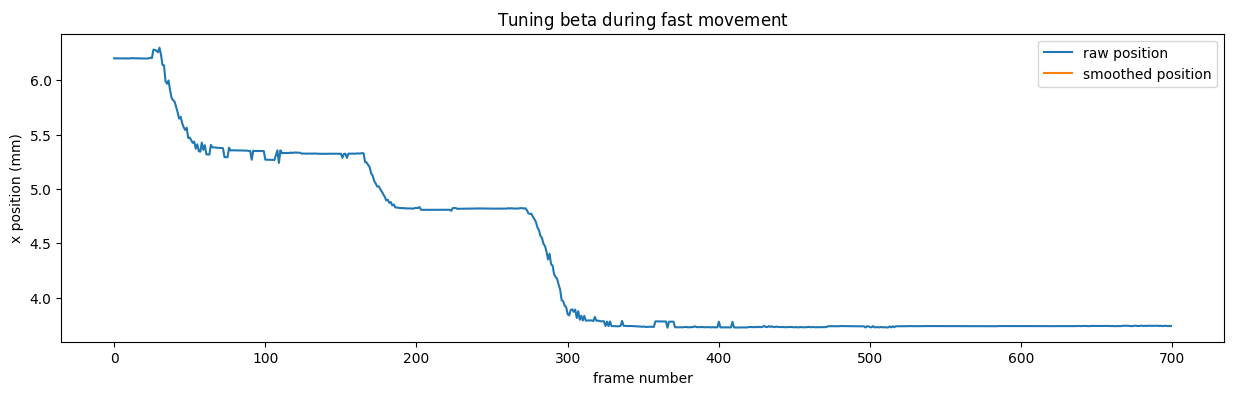

In [102]:
IdSt = np.random.randint(x.shape[0])
Duration = 2*tracking_cfg.fps

x = traj.x
x_smooth = TrajPreprocessing.one_euro_filter(x,freq_cutoff_min=8,beta=1.4,rate=tracking_cfg.fps)

fig,ax = plt.subplots(1,1,figsize=(15,4),sharex=True)
ax.set_title('Tuning '+ r'$\text{beta}$'+ ' during fast movement')
ax.plot(x[IdSt:IdSt+Duration],label='raw position')
ax.plot(x_smooth[IdSt:IdSt+Duration],label='smoothed position')
ax.set(xlabel='frame number',ylabel='x position (mm)')
ax.legend()
plt.show()

&#x2705;	*Here we selected `beta=1.4`*